In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from snAPI.Main import *
import pandas as pd
sys.path.append("../")
from HH import HH_T3
from Functions import *
import time

In [25]:
filename='../../../Acquisition2/Data/Trial_markers/T/PTU_4.ptu'
os.listdir(filename)

NotADirectoryError: [WinError 267] El nombre del directorio no es válido: '../../../Acquisition2/Data/Trial_markers/T/PTU_4.ptu'

In [26]:
sn=snAPI()
sn.getDevice()
sn.getFileDevice(filename)
sn.initDevice(MeasMode.T3)

True

In [27]:
t_resol=sn.deviceConfig['Resolution']/1000 #in ns
sn.raw.measure()
data = sn.raw.getData()

In [48]:
markers_Bool=np.array([sn.raw.isMarker(datai) for datai in data])


0

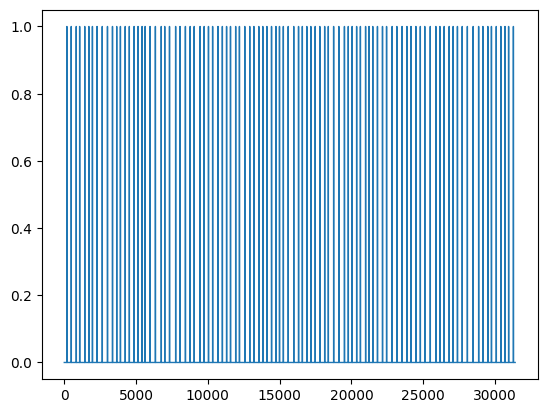

In [42]:
plt.plot(markers_Bool,linewidth=1)

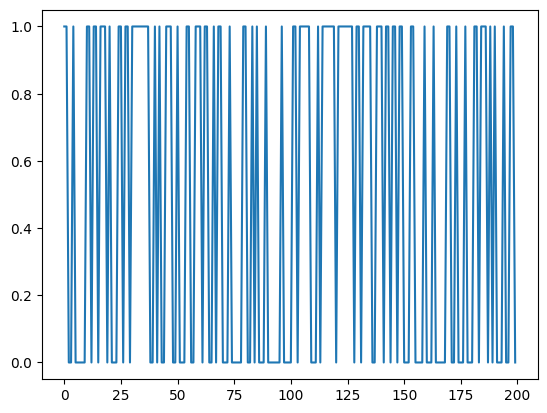

In [51]:
plt.plot(sn.raw.markers(data)[0][0:200])

In [52]:
markers_Bool

array([False, False, False, ..., False, False, False])